# Temat 2: Adaline i metoda gradientu prostego

In [1]:
import os
import pandas as pd

try:
    s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
    print('From URL:', s)
    df = pd.read_csv(s,
                     header=None,  # Plik nie zawiera wiersza nagłówkowego z nazwami kolumn
                     encoding='utf-8')  # Określa kodowanie znaków pliku
    
except HTTPError:
    s = 'iris.data'
    print('From local Iris path:', s)
    # Wczytanie danych z lokalnej ścieżki:
    df = pd.read_csv(s,
                     header=None,
                     encoding='utf-8')

/Users/jedrzejsarna/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


From URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


In [2]:
import numpy as np

# Wydzielamy dwa gatunki (setosa oraz versicolor):
y = df.iloc[0:100, 4].values  # Wybiera wiersze od 0 do 99 i 5-tą kolumnę
                              # Metoda .values konwertuje tę kolumnę na tablicę NumPy
y = np.where(y == 'Iris-setosa', 0, 1)

# Wydzielamy dwie cechy (sepal length oraz petal length):
X = df.iloc[0:100, [0, 2]].values

In [3]:
# Poniższy kod przedstawia implementację funkcji,
# która wizualizuje granicę decyzyjną klasyfikatora dla dwuwymiarowej przestrzeni cech.

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, resolution=0.02):  # resolution - rozmiar kroku siatki do wizualizacji przestrzeni

    # Definiujemy listy markerów i kolorów, które będą używane do reprezentowania różnych klas na wykresie:
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    # Tworzymy mapę kolorów ListedColormap na podstawie kolorów określonych w colors. 
    # cmap to obiekt, który Matplotlib używa do mapowania liczb na kolory
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # Wykres obszarów decyzyjnych:
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1  # Określamy zakresy wartości dla obu cech (-/+ 1)
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))  # Tworzymy dwuwymiarową siatkę punktów do wizualizacji przestrzeni cech
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)  # Liczymy predykcje dla każdego punktu siatki
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)  # Rysowanie konturu granic decyzyjnych
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())  # Ustawiono granice osi wykresu

    # Rysowanie przykładów z rozważanych klas:
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

In [4]:
import numpy as np  # Wykorzystana do przekształceń z tablicami oraz do generowania liczb losowych

class AdalineGD:
    """ADAptive LInear NEuron classifier. (GD = Gradient Descent)

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    losses_ : list
      Mean squared eror loss function values in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        
        self.losses_ = []  # Zamiast self.errors_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # W przypadku Adaline funkcji activation() nie musimy tak naprawdę definiować,
            # ponieważ jest ona funkcją tożsamościową
            # (można by napisać wprost output = self.net_input(X)).
            # Definiujemy metodę activation jedynie dla uniwersalności kodu
            # (łatwo można np. przerobić go na regresję logistyczną, używając funkcji sigmoidalnej).
            output = self.activation(net_input)
            errors = (y - output)    
            
            # Można tak, ale byłoby mniej efektywnie:
            # for w_j in range(self.w_.shape[0]):
            #    self.w_[w_j] += self.eta * (2.0 * (X[:, w_j]*errors)).mean()
            
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)  # Zmiana na >= 0.5

In [5]:
class AdalineSGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
      Mean squared error loss function value averaged over all
      training examples in each epoch.

        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float_(0.)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

# Zadanie 2.1

In [6]:
eta=[0.5,0.2,0.1,0.01,0.001,0.0001]

## 1 scenariusz

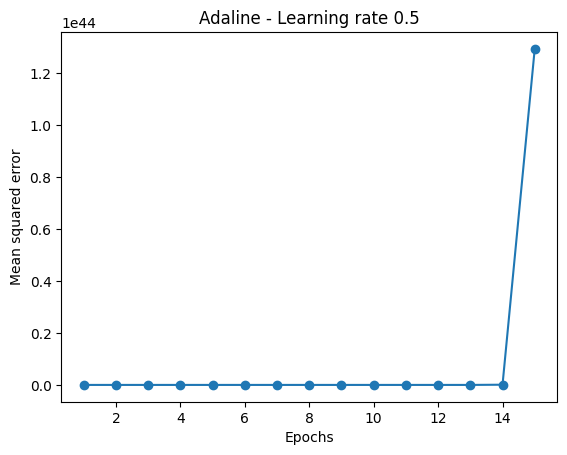

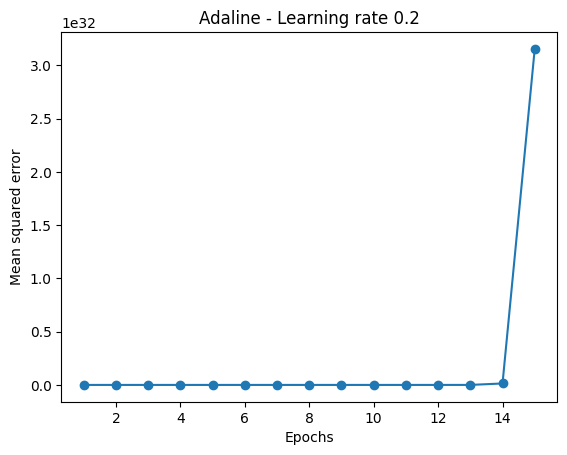

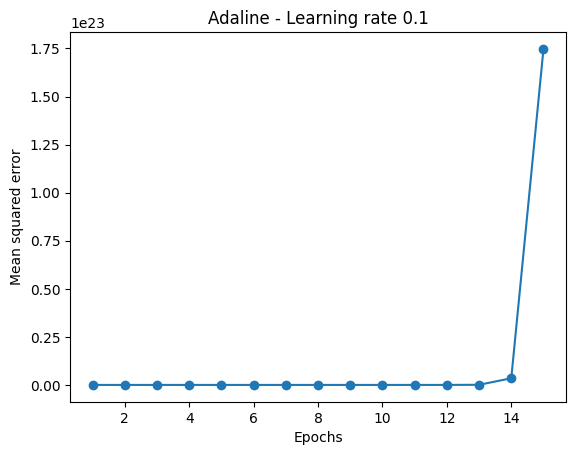

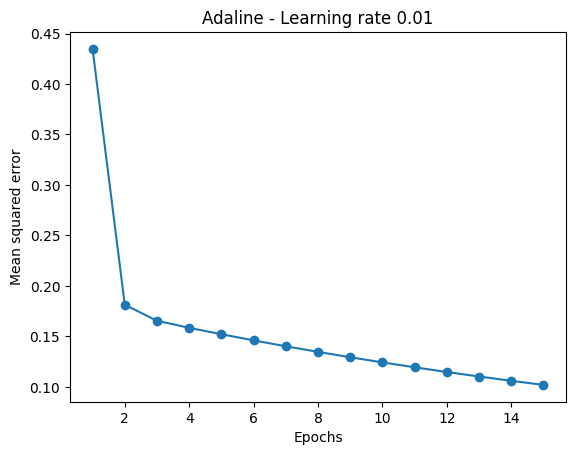

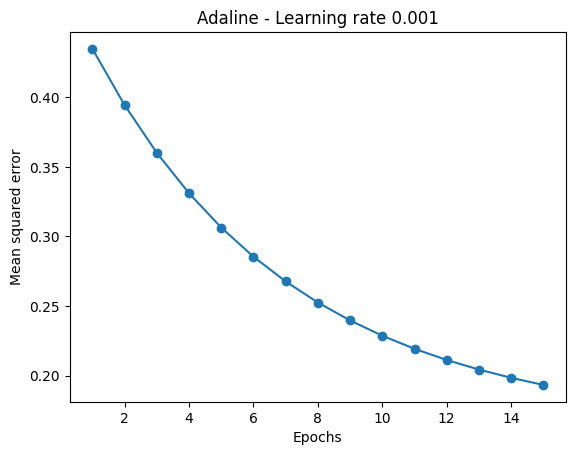

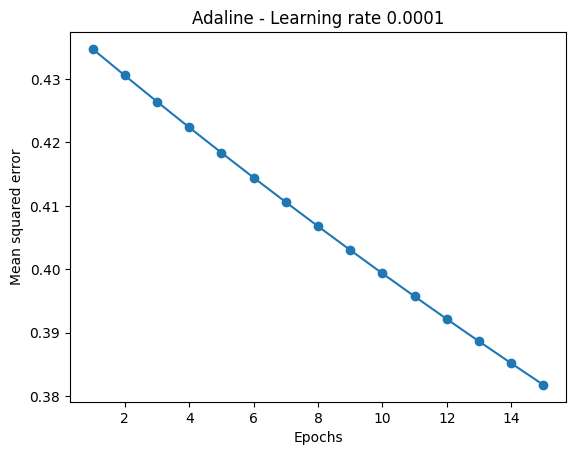

In [7]:
# 1 scenariusz
for i in range(len(eta)):
    ada1 = AdalineGD(n_iter=15, eta=eta[i]).fit(X, y)
    plt.plot(range(1, len(ada1.losses_) + 1), ada1.losses_, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Mean squared error')
    plt.title(f'Adaline - Learning rate {eta[i]}')
    plt.show()

## 2 scenariusz

In [8]:
# Standaryzacja cech (mean oraz std z NumPy):
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

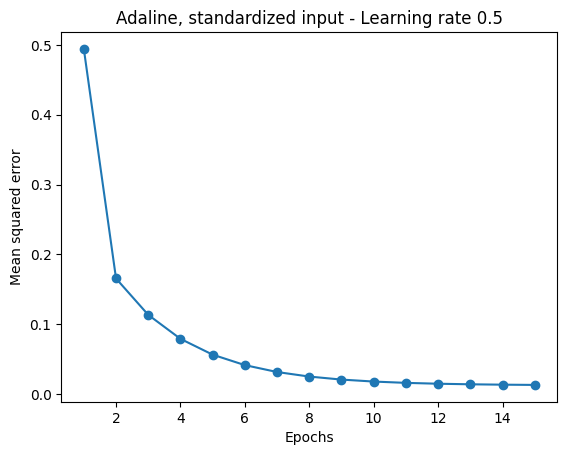

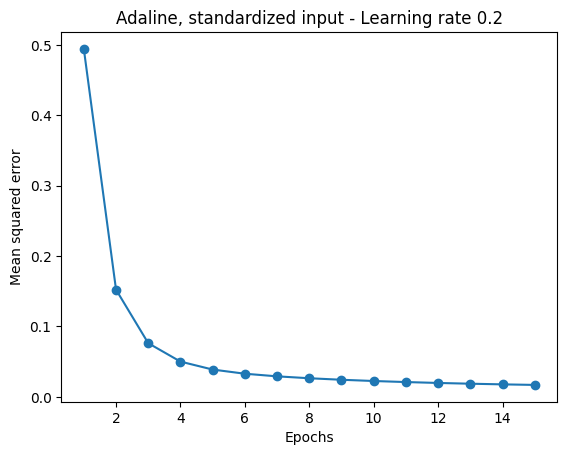

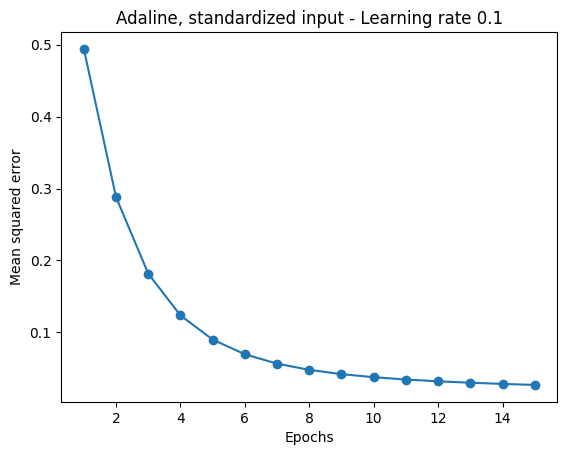

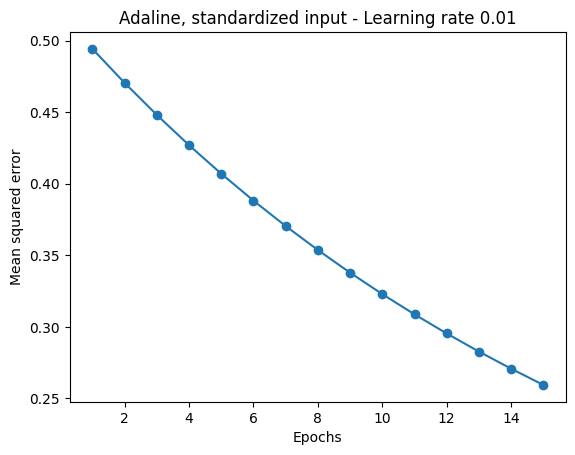

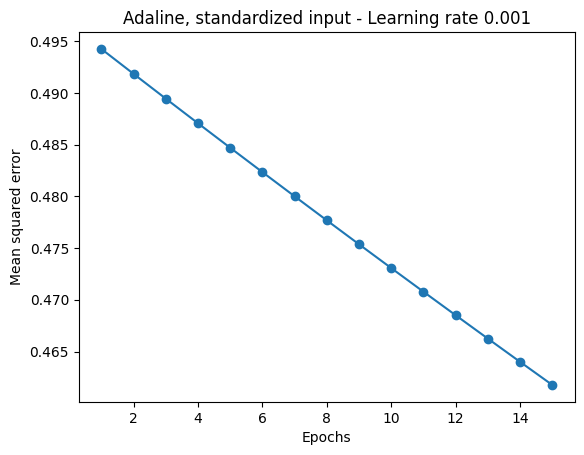

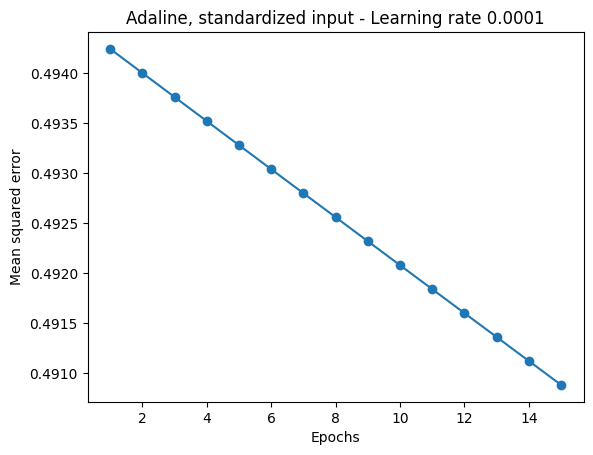

In [9]:
# 2 scenariusz
for i in range(len(eta)):
    ada1 = AdalineGD(n_iter=15, eta=eta[i]).fit(X_std, y)
    plt.plot(range(1, len(ada1.losses_) + 1), ada1.losses_, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Mean squared error')
    plt.title(f'Adaline, standardized input - Learning rate {eta[i]}')
    plt.show()

## 3 scenariusz

/var/folders/n3/4qctfjhd43j9h6fypc3p1h480000gn/T/ipykernel_23248/2949989453.py:93: RuntimeWarning: overflow encountered in scalar power
  loss = error**2
/var/folders/n3/4qctfjhd43j9h6fypc3p1h480000gn/T/ipykernel_23248/2949989453.py:91: RuntimeWarning: invalid value encountered in add
  self.w_ += self.eta * 2.0 * xi * (error)
/var/folders/n3/4qctfjhd43j9h6fypc3p1h480000gn/T/ipykernel_23248/2949989453.py:92: RuntimeWarning: invalid value encountered in scalar add
  self.b_ += self.eta * 2.0 * error


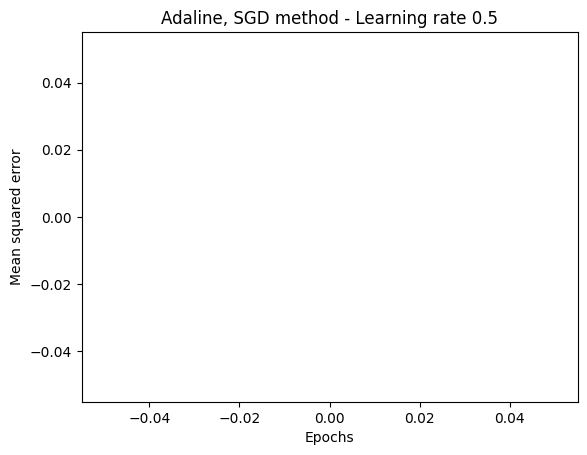

/var/folders/n3/4qctfjhd43j9h6fypc3p1h480000gn/T/ipykernel_23248/2949989453.py:91: RuntimeWarning: overflow encountered in multiply
  self.w_ += self.eta * 2.0 * xi * (error)


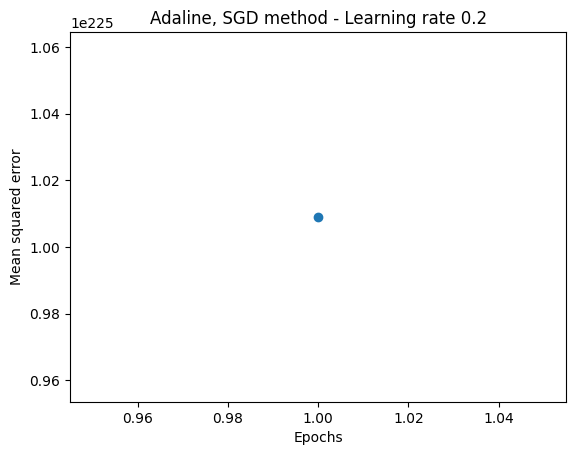

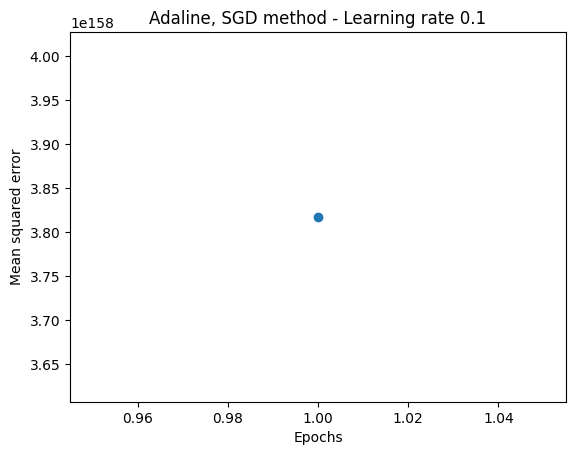

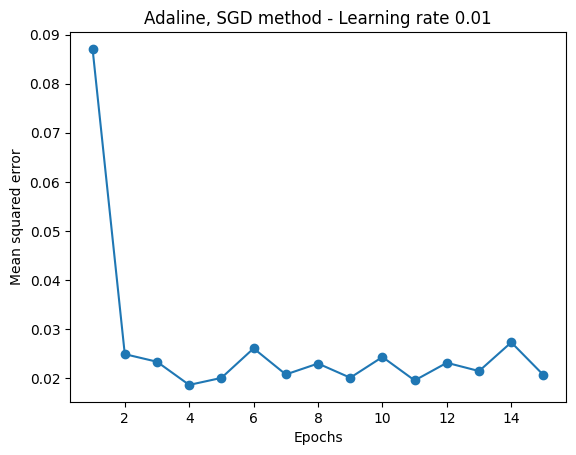

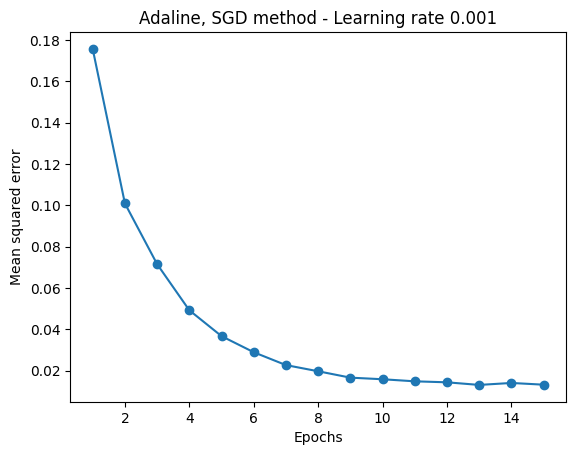

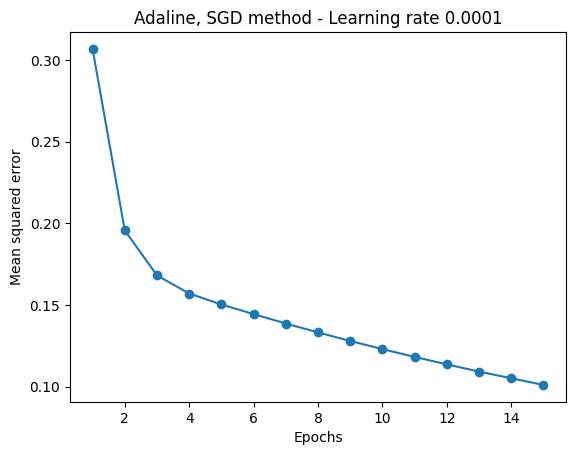

In [10]:
# 3 scenariusz
for i in range(len(eta)):
    ada1 = AdalineSGD(n_iter=15, eta=eta[i], random_state=1).fit(X, y)
    plt.plot(range(1, len(ada1.losses_) + 1), ada1.losses_, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Mean squared error')
    plt.title(f'Adaline, SGD method - Learning rate {eta[i]}')
    plt.show()

## 4 scenariusz

/var/folders/n3/4qctfjhd43j9h6fypc3p1h480000gn/T/ipykernel_23248/2949989453.py:93: RuntimeWarning: overflow encountered in scalar power
  loss = error**2


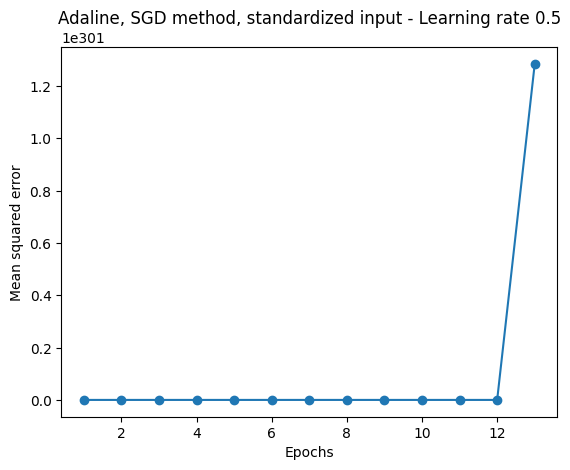

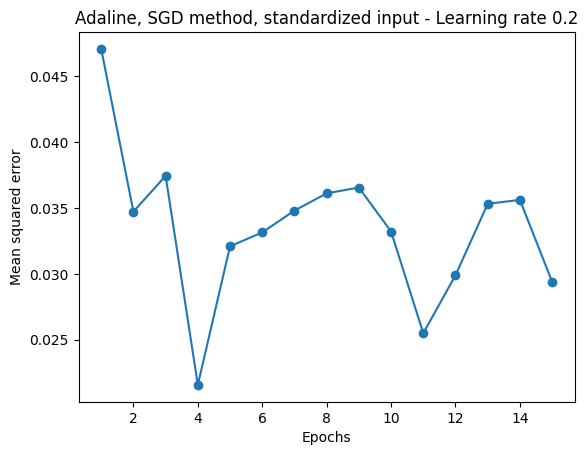

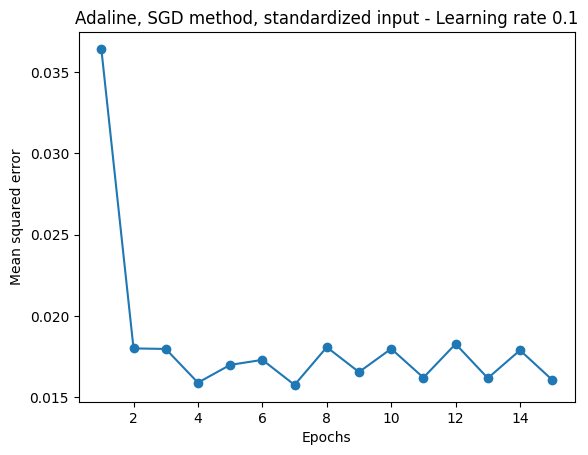

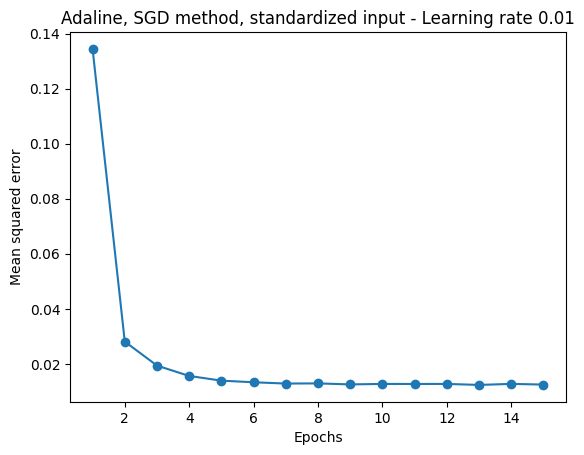

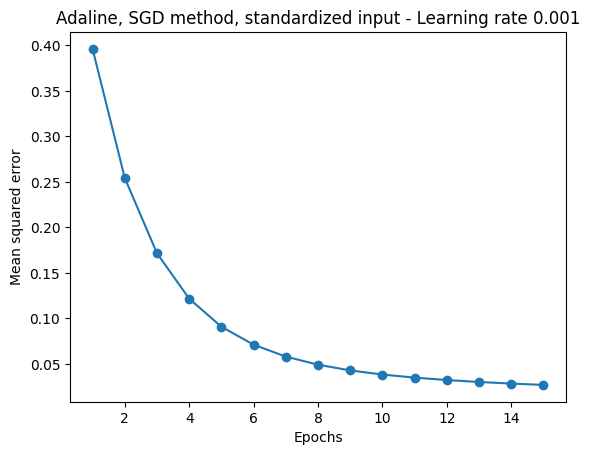

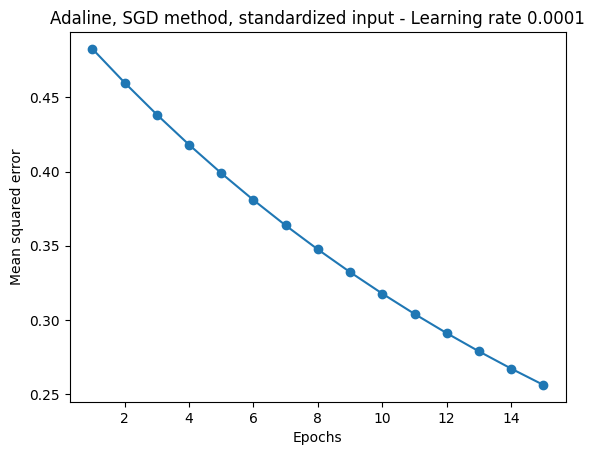

In [11]:
# 4 scenariusz
for i in range(len(eta)):
    ada1 = AdalineSGD(n_iter=15, eta=eta[i], random_state=1).fit(X_std, y)
    plt.plot(range(1, len(ada1.losses_) + 1), ada1.losses_, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Mean squared error')
    plt.title(f'Adaline, SGD method, standardized input - Learning rate {eta[i]}')
    plt.show()

1. Adaline z wykorzystaniem wsadowej wersji metody gradientu prostego, bez standaryzacji cech, $\eta = 0.01$
2. Adaline z wykorzystaniem wsadowej wersji metody gradientu prostego, ze standaryzacją cech, $\eta = 0.1$
3. Adaline z wykorzystaniem wersji SGD metody gradientu prostego (aproksymacja funkcji celu na podstawie jednego przykładu), bez standaryzacji cech, $\eta = 0.01$
4. Adaline z wykorzystaniem wersji SGD metody gradientu prostego (aproksymacja funkcji celu na podstawie jednego przykładu), ze standaryzacją cech. $\eta = 0.1$

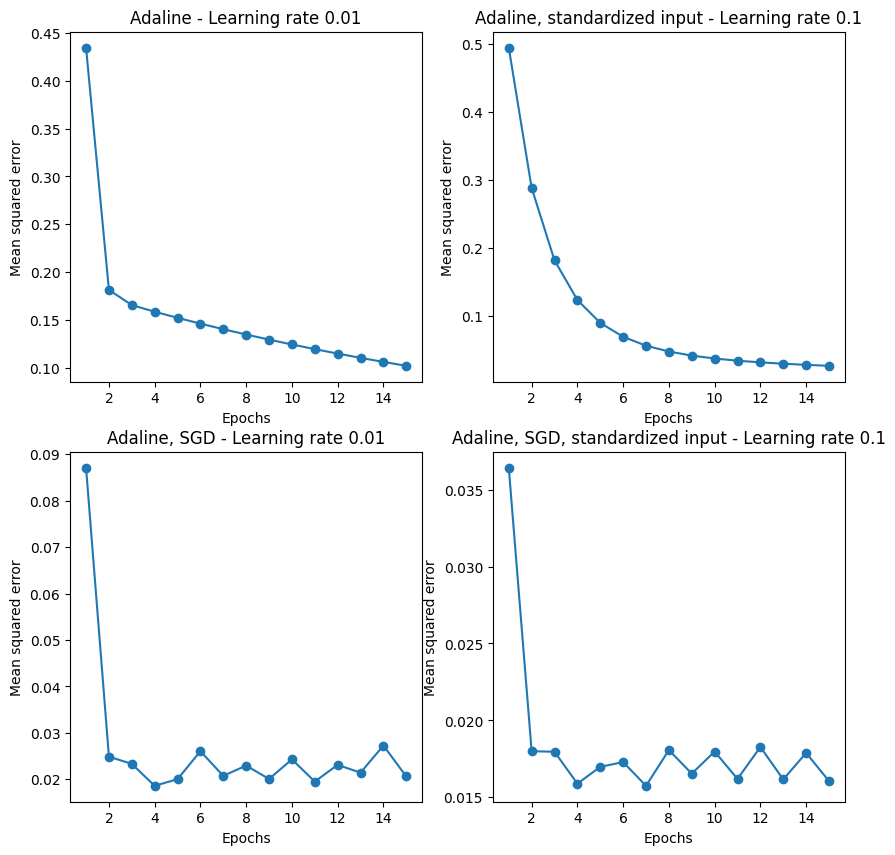

In [12]:
#porownanie szybkosci zbieznosci dla AdalineGD i AdalineSGD

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ada1 = AdalineGD(n_iter=15, eta=0.01).fit(X, y)
ax[0,0].plot(range(1, len(ada1.losses_) + 1), ada1.losses_, marker='o')
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Mean squared error')
ax[0,0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=15, eta=0.1).fit(X_std, y)
ax[0,1].plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker='o')
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('Mean squared error')
ax[0,1].set_title('Adaline, standardized input - Learning rate 0.1')

ada3 = AdalineSGD(n_iter=15, eta=0.01, random_state=1).fit(X, y)
ax[1,0].plot(range(1, len(ada3.losses_) + 1), ada3.losses_, marker='o')
ax[1,0].set_xlabel('Epochs')
ax[1,0].set_ylabel('Mean squared error')
ax[1,0].set_title('Adaline, SGD - Learning rate 0.01')

ada4 = AdalineSGD(n_iter=15, eta=0.1, random_state=1).fit(X_std, y)
ax[1,1].plot(range(1, len(ada4.losses_) + 1), ada4.losses_, marker='o')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Mean squared error')
ax[1,1].set_title('Adaline, SGD, standardized input - Learning rate 0.1')

plt.show()

Widać, ze modele otrzymane metoda SGD "najszybciej sie ucza", MSE najszybciej osiaga niskie wartosci (dla 2 epoki w zasadzie 10 razy mniejsze wartosci niz dla zwyklej metody gradientu prostego, sredni blad wynosi w okolicach 0.02 co wydaje sie byc juz zadowalajacym wynikiem). Widac tez ze do 4 epoki blad caly czas sie zmniejsza i tam osiaga (mniej wiecej) minimalny blad, pozniej juz blad sie zwieksza (przez losowosc). Dla zwyklej metody gradientu prostego blad caly czas spada jednak wymaga wiele epok aby dojsc do wielkosci bledu metoda SGD.

# Zadanie 2.2 

Najlepsze podejście to scenariusz 4, więc ten bierzemy.

In [13]:
y = df.iloc[:, 4].values  # Wybiera wszystkie wiersze i 5-tą kolumnę

X = df.iloc[:, 0:4].values
# standaryzacja cech
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()
X_std[:, 2] = (X[:, 2] - X[:, 2].mean()) / X[:, 2].std()
X_std[:, 3] = (X[:, 3] - X[:, 3].mean()) / X[:, 3].std()

#model 1
y1 = np.where(y == 'Iris-setosa', 1, 0)
ada1 = AdalineSGD(n_iter=15, eta=0.1, random_state=1).fit(X_std, y1)

#model 2
y2 = np.where(y == 'Iris-versicolor', 1, 0)
ada2 = AdalineSGD(n_iter=15, eta=0.1, random_state=1).fit(X_std, y2)

#model 3
y3 = np.where(y == 'Iris-virginica', 1, 0)
ada3 = AdalineSGD(n_iter=15, eta=0.1, random_state=1).fit(X_std, y3)


In [21]:
# Stack the arrays
stacked_arrays = np.vstack([ada1.net_input(X_std), ada2.net_input(X_std), ada3.net_input(X_std)])

# Find the max values and their indices
max_values = np.max(stacked_arrays, axis=0)
max_indices = np.argmax(stacked_arrays, axis=0)

print(max_indices)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 1 1 1 2 1 1 2 1 2 1 1 2 1 2 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 1 1 2 1 1 1 1 1 1 1 1 1 0 1 2 2 1 1 2 1 2 1 1 2 2
 1 1 2 2 2 1 1 1 1 2 2 1 1 2 1 1 2 1 1 1 1 2 1 1 1 2 1 2 2 2 2 2 2 2 2 1 2
 2 2]


## Błąd jako procent źle przewidzianych etykiet (1-dokładność)

In [20]:
# Define the species mapping
species_mapping = {
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2
}
# Apply the mapping to encode the species
encoded_species = [species_mapping[species] for species in y]
print(encoded_species)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [26]:
counter = np.sum(max_indices == encoded_species)
print(150-counter)
print(100 - counter/len(y) * 100)

35
23.33333333333333


## Błąd jako błąd średniokwadratowy

In [17]:
one_hot_mapping = {
    'Iris-setosa': [1, 0, 0],
    'Iris-versicolor': [0, 1, 0],
    'Iris-virginica': [0, 0, 1]
}

# Apply the mapping to each species in the list
one_hot_encoded = [one_hot_mapping[species] for species in y]

print(one_hot_encoded)

[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0]

In [23]:
result = []

# Iterate through each index and max value
for index, max_val in enumerate(max_values):
    # Create a zero-filled list
    new_list = [0, 0, 0]
    
    # Place the max value in the position indicated by max_indices
    new_list[max_indices[index]] = max_val
    
    # Append this list to the result
    result.append(new_list)

# Convert the result to a NumPy array if desired
result_array = np.array(result)
print(result_array)

[[1.09333148 0.         0.        ]
 [0.9587984  0.         0.        ]
 [1.04392158 0.         0.        ]
 [0.96996196 0.         0.        ]
 [1.1237532  0.         0.        ]
 [1.11478098 0.         0.        ]
 [1.07306317 0.         0.        ]
 [1.0436516  0.         0.        ]
 [0.94344141 0.         0.        ]
 [0.96734091 0.         0.        ]
 [1.11734124 0.         0.        ]
 [1.02439344 0.         0.        ]
 [0.96622051 0.         0.        ]
 [1.05161368 0.         0.        ]
 [1.26387009 0.         0.        ]
 [1.29536275 0.         0.        ]
 [1.21189994 0.         0.        ]
 [1.08842016 0.         0.        ]
 [1.084249   0.         0.        ]
 [1.14787321 0.         0.        ]
 [0.98504896 0.         0.        ]
 [1.11505096 0.         0.        ]
 [1.23091532 0.         0.        ]
 [0.94993643 0.         0.        ]
 [0.95155421 0.         0.        ]
 [0.90772813 0.         0.        ]
 [1.00954922 0.         0.        ]
 [1.06654095 0.         0.  

In [24]:
# Calculate MAE
mae = np.mean(np.abs(one_hot_encoded - result_array))

print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.18988801627533267


# Zadanie 2.3

In [164]:
import numpy as np

class AdalineSGD:
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None, mini_batch_size=10):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        self.mini_batch_size = mini_batch_size

    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            mini_batches = self._create_mini_batches(X, y, self.mini_batch_size)
            losses = []
            for X_mini, y_mini in mini_batches:
                losses.append(self._update_weights(X_mini, y_mini))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _create_mini_batches(self, X, y, mini_batch_size):
        mini_batches = []
        data = np.hstack((X, y.reshape(-1, 1)))
        np.random.shuffle(data)
        n_minibatches = data.shape[0] // mini_batch_size
        for i in range(n_minibatches + 1):
            mini_batch = data[i * mini_batch_size:(i + 1) * mini_batch_size, :]
            X_mini, y_mini = mini_batch[:, :-1], mini_batch[:, -1]
            mini_batches.append((X_mini, y_mini))
        if data.shape[0] % mini_batch_size != 0:
            mini_batch = data[i * mini_batch_size:data.shape[0]]
            X_mini, y_mini = mini_batch[:, :-1], mini_batch[:, -1]
            mini_batches.append((X_mini, y_mini))
        return mini_batches

    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float_(0.)
        self.w_initialized = True

    def _update_weights(self, X, y):
        output = self.activation(self.net_input(X))
        error = (y - output)
        self.w_ += self.eta * X.T.dot(error)
        self.b_ += self.eta * error.sum()
        loss = (error**2).sum() / X.shape[0]
        return loss

    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        return X

    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)


/var/folders/n3/4qctfjhd43j9h6fypc3p1h480000gn/T/ipykernel_20181/3839353699.py:62: RuntimeWarning: invalid value encountered in scalar divide
  loss = (error**2).sum() / X.shape[0]


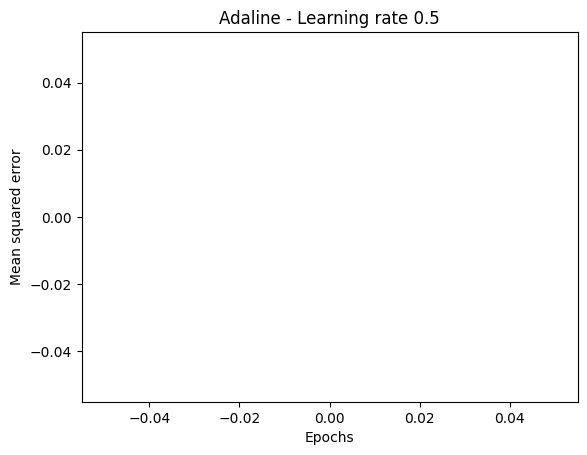

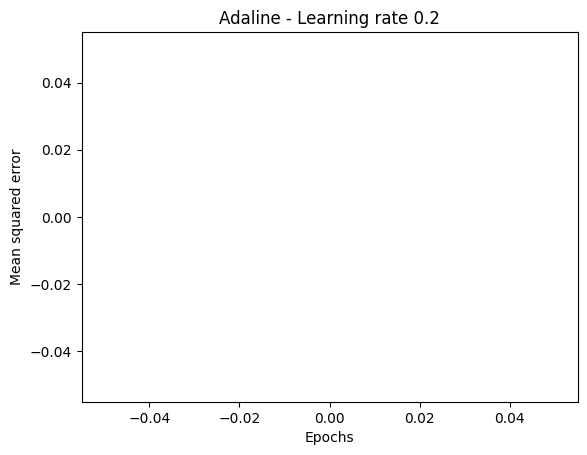

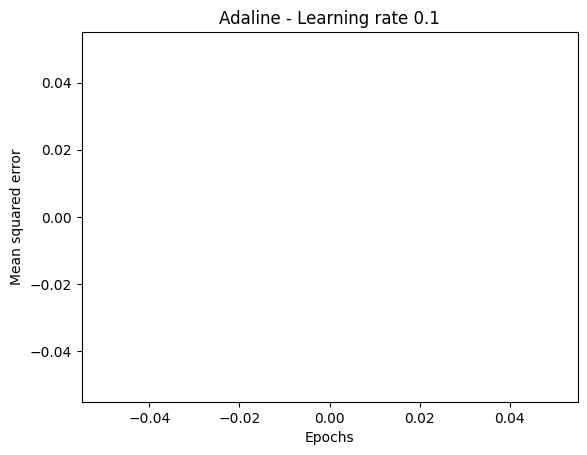

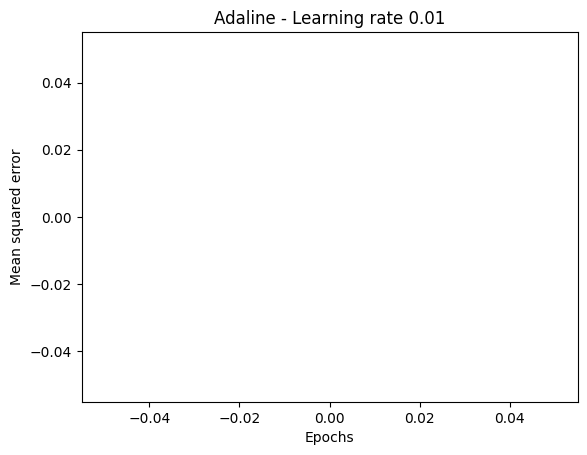

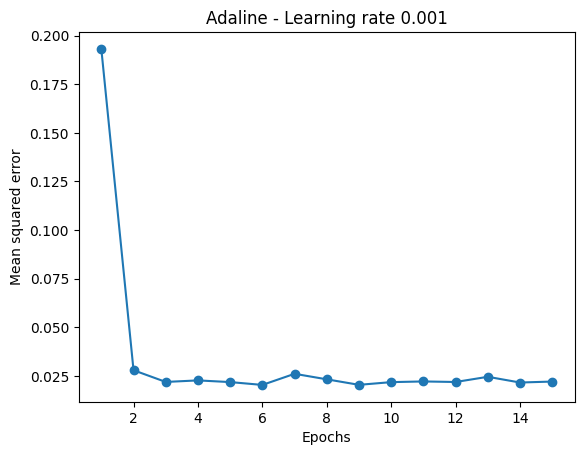

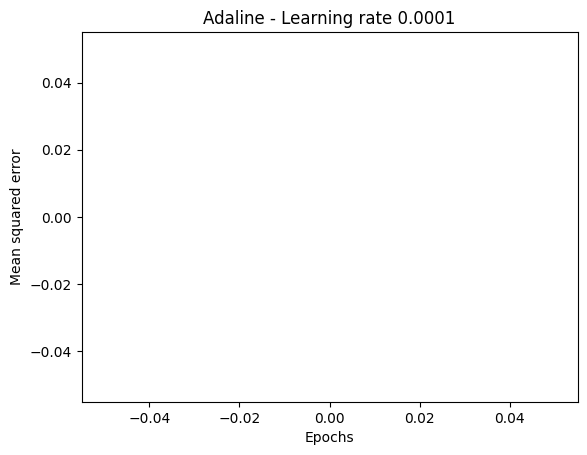

In [167]:
mini_batch_sizes = [1, 2,5, 10, 20, 50]
for i in range(len(mini_batch_sizes)):
    ada1 = AdalineSGD(n_iter=15, eta=0.01, mini_batch_size=mini_batch_sizes[i]).fit(X_std, y)
    plt.plot(range(1, len(ada1.losses_) + 1), ada1.losses_, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Mean squared error')
    plt.title(f'Adaline - Learning rate {eta[i]}')
    plt.show()

# Zadanie 2.4

In [161]:
ada1 = AdalineSGD(n_iter=15, eta=0.01, random_state=1)


y = df.iloc[:, 4].values  
y = np.where(y == 'Iris-setosa', 0, 1)

X = df.iloc[:, 0:4].values
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()
X_std[:, 2] = (X[:, 2] - X[:, 2].mean()) / X[:, 2].std()
X_std[:, 3] = (X[:, 3] - X[:, 3].mean()) / X[:, 3].std()

losses_all = []

for end_idx in range(1, len(y)-1, 1):
    ada1 = AdalineSGD(n_iter=15, eta=0.01, random_state=1).fit(X_std[:end_idx], y[:end_idx]).partial_fit(X_std[:end_idx+1,:], y[:end_idx])
    losses_all.append(ada1.losses_)

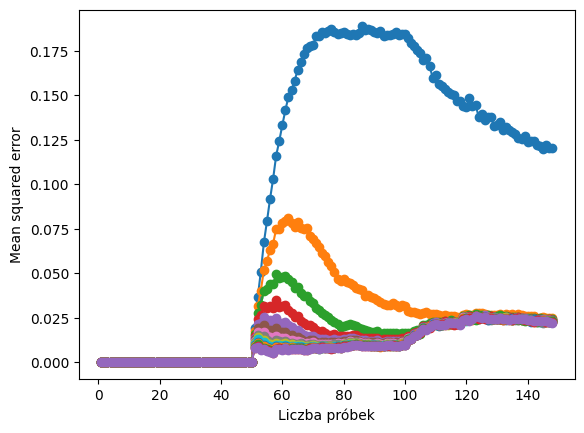

In [163]:
plt.plot(range(1, len(losses_all) + 1), losses_all, marker='o')
plt.xlabel('Liczba próbek')
plt.ylabel('Mean squared error')
plt.title(f'')
plt.show()